In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset
import numpy as np

from src.gan.generator import Generator
from src.gan.discriminator import Discriminator

from src.data_loaders.datasets.fashion_mnist_dataset import FashionMNISTDataset
from src.data_loaders.datasets.generated_fake_dataset import GeneratedFakeDataset
from src.data_loaders.datasource import show_images_from_tensor
from src.classic.utils import count_model_parameters

In [2]:
device = torch.device("cuda:0")

In [3]:
#models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=40, output_dim=784).to(device)
discriminator = Discriminator(hidden_dim=40, input_dim=784).to(device)

In [4]:
for p in generator.parameters():
    print(p.numel())

1280
40
1600
40
31360
784


In [5]:
for p in discriminator.parameters():
    print(p.numel())

31360
40
1600
40
40
1


In [6]:
print(f"Generator parameters: {count_model_parameters(generator)}")
print(f"Discriminator parameters: {count_model_parameters(discriminator)}")

Generator parameters: 35104
Discriminator parameters: 33081


In [19]:
generator.load_state_dict(torch.load("../pre-trained/generator"))
discriminator.load_state_dict(torch.load("../pre-trained/discriminator"))

<All keys matched successfully>

In [9]:
fashionMNIST = FashionMNISTDataset()
train_data_real = fashionMNIST.train_data

generated_fake_dataset = GeneratedFakeDataset(generator, len(train_data_real))
train_data_fake = generated_fake_dataset.train_dataset

train_data_merged = torch.cat([train_data_real, train_data_fake], 0)

In [10]:
train_targets_real = fashionMNIST.get_train_set_targets()

train_targets_fake = generated_fake_dataset.get_train_set_targets()

train_targets_merged = torch.cat([train_targets_real, train_targets_fake], 0).unsqueeze(1)

In [11]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [12]:
train_loader = data.DataLoader(TensorDataset(train_data_merged, train_targets_merged), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
train_loader_real = data.DataLoader(TensorDataset(train_data_real, train_targets_real), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
train_loader_fake = data.DataLoader(TensorDataset(train_data_fake, train_targets_fake), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [13]:
from torch.utils.data import ConcatDataset

merged_train_loader = data.DataLoader(TensorDataset(train_data_real, train_targets_real, train_data_fake, train_targets_fake), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [14]:
def show_sample_predictions(discriminator, my_data_loader_batch):
    show_images_from_tensor(my_data_loader_batch[0].cpu())
    predictions = discriminator(my_data_loader_batch[0].to(device)).cpu()
    print(predictions)
    print(f"Loss: {criterion(predictions.cuda(), my_data_loader_batch[1].cuda())}")

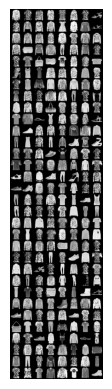

tensor([[ 5.4491e-02],
        [ 6.4784e-04],
        [ 2.1814e-01],
        [-5.0836e-03],
        [ 7.9959e-02],
        [ 1.7660e-01],
        [ 1.1826e-01],
        [ 1.0524e+00],
        [ 3.2091e-01],
        [ 1.0975e+00],
        [ 2.5685e-01],
        [-1.0641e-01],
        [ 1.0137e+00],
        [ 7.5184e-02],
        [ 7.3121e-01],
        [ 9.5400e-01],
        [-9.5960e-02],
        [-2.6724e-02],
        [ 6.6912e-02],
        [-9.8096e-02],
        [-9.8551e-02],
        [ 1.5459e-01],
        [-1.1239e-01],
        [ 1.0518e+00],
        [-3.1132e-02],
        [ 1.0054e+00],
        [ 1.1818e+00],
        [ 8.3057e-02],
        [ 9.6375e-01],
        [ 9.6228e-02],
        [ 9.7233e-01],
        [-7.2754e-02],
        [ 3.5599e-01],
        [ 7.3561e-02],
        [ 1.0446e+00],
        [ 9.5112e-01],
        [ 6.7091e-01],
        [ 3.0968e-01],
        [-1.8317e-01],
        [ 9.1395e-01],
        [ 8.7577e-01],
        [ 1.0717e+00],
        [ 7.7499e-01],
        [ 6

In [15]:
show_sample_predictions(discriminator, next(iter(train_loader)))

In [22]:
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_real_acc = []
    discriminator_fake_acc = []
    discriminator_error_real = []
    discriminator_error_fake = []

    for i, batch in enumerate(merged_train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        images_real = batch[0].to(device)
        # b_size = images.size(0)
        # label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        label_real = batch[1].float().to(device)
        # Forward pass real batch through D
        output = discriminator(images_real).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label_real)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_error_real.append(error_discriminator_real.mean().item())
        discriminator_real_acc.append(output.mean().item())
        # Update D
        discriminator_optimizer.step()

        discriminator_optimizer.zero_grad() # pierwotnie go tu nie było
        ## Train with all-fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        # fake_images = generator(noise)
        # label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        fake_offset = 2
        fake_images = batch[fake_offset + 0].to(device)
        label_fake = batch[fake_offset + 1].float().to(device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_error_fake.append(error_discriminator_fake.mean().item())
        discriminator_fake_acc.append(output.mean().item())

        # # Compute error of D as sum over the fake and the real batches
        # error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

    print(f"Epoch: {epoch}, discriminator real mean output: {np.mean(discriminator_real_acc):.3}")
    print(f"Epoch: {epoch}, discriminator real mean error: {np.mean(discriminator_error_real):.3}")
    print(f"Epoch: {epoch}, discriminator fake mean output: {np.mean(discriminator_fake_acc):.3}")
    print(f"Epoch: {epoch}, discriminator fake mean error: {np.mean(discriminator_error_fake):.3}")

Epoch: 0, discriminator real mean output: 0.996
Epoch: 0, discriminator real mean error: 0.00599
Epoch: 0, discriminator fake mean output: 0.00331
Epoch: 0, discriminator fake mean error: 0.00246
Epoch: 1, discriminator real mean output: 0.996
Epoch: 1, discriminator real mean error: 0.00497
Epoch: 1, discriminator fake mean output: 0.00278
Epoch: 1, discriminator fake mean error: 0.00216
Epoch: 2, discriminator real mean output: 0.997
Epoch: 2, discriminator real mean error: 0.00419
Epoch: 2, discriminator fake mean output: 0.00244
Epoch: 2, discriminator fake mean error: 0.00189
Epoch: 3, discriminator real mean output: 0.997
Epoch: 3, discriminator real mean error: 0.00361
Epoch: 3, discriminator fake mean output: 0.00231
Epoch: 3, discriminator fake mean error: 0.00164
Epoch: 4, discriminator real mean output: 0.997
Epoch: 4, discriminator real mean error: 0.00317
Epoch: 4, discriminator fake mean output: 0.00205
Epoch: 4, discriminator fake mean error: 0.00152


RuntimeError: DataLoader worker (pid(s) 15076, 21560) exited unexpectedly

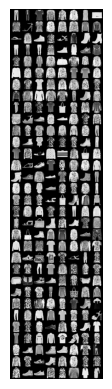

tensor([[ 9.8983e-01],
        [ 9.9656e-01],
        [ 9.9122e-01],
        [ 6.2125e-02],
        [-1.0558e-03],
        [ 6.1696e-02],
        [ 1.0206e+00],
        [ 9.7063e-01],
        [-7.2380e-02],
        [ 9.4047e-01],
        [ 5.0048e-02],
        [ 4.0558e-02],
        [ 3.8930e-02],
        [ 2.4137e-02],
        [ 9.4669e-01],
        [ 9.4135e-01],
        [ 1.0037e+00],
        [ 1.4307e-02],
        [ 1.0207e+00],
        [ 8.2974e-02],
        [ 1.0352e+00],
        [ 1.1235e+00],
        [ 1.0631e+00],
        [ 1.0337e+00],
        [ 9.9886e-01],
        [ 9.9332e-01],
        [ 9.9393e-01],
        [-2.3662e-02],
        [ 9.8040e-01],
        [ 9.2873e-01],
        [ 9.8256e-01],
        [ 7.8056e-01],
        [-9.9977e-03],
        [-3.4525e-02],
        [ 1.0207e+00],
        [ 3.7984e-02],
        [ 1.0336e+00],
        [-3.9140e-02],
        [ 1.0492e+00],
        [-4.2150e-02],
        [ 1.0207e+00],
        [ 4.5360e-02],
        [ 4.2619e-02],
        [ 8

In [23]:
show_sample_predictions(discriminator, next(iter(train_loader)))

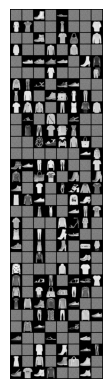

tensor([[-3.1381e-03],
        [-5.0023e-03],
        [ 1.0123e+00],
        [-1.8533e-03],
        [ 9.8484e-01],
        [-2.1170e-03],
        [-3.0448e-03],
        [-3.0558e-03],
        [ 9.8634e-01],
        [ 9.9160e-01],
        [-2.4920e-03],
        [-2.8445e-03],
        [ 9.9335e-01],
        [-3.2922e-03],
        [-2.6878e-03],
        [ 9.8664e-01],
        [-7.5630e-04],
        [-1.9928e-03],
        [ 9.9957e-01],
        [-1.8759e-03],
        [ 9.9352e-01],
        [ 9.8492e-01],
        [-1.1064e-03],
        [ 9.9833e-01],
        [ 9.8952e-01],
        [-1.4109e-03],
        [-1.6476e-03],
        [ 9.9026e-01],
        [-4.8330e-03],
        [ 9.9041e-01],
        [-1.3750e-04],
        [-4.1591e-03],
        [-5.6397e-04],
        [ 1.0021e+00],
        [ 9.9988e-01],
        [ 1.0121e+00],
        [ 9.9921e-01],
        [-6.5797e-04],
        [ 9.9237e-01],
        [ 9.9555e-01],
        [-3.6628e-03],
        [-2.8852e-03],
        [-4.1169e-03],
        [ 1

In [26]:
show_sample_predictions(discriminator, next(iter(train_loader)))